# 3.4 Shrinkage Methods

By retaining a subset of the predictors and discarding the rest, subset selection produces a model that is interpretable and has possibly lower prediction error than the full model. However, because it is a discrete process— variables are either retained or discarded—it often exhibits high variance, and so doesn’t reduce the prediction error of the full model. Shrinkage methods are more continuous, and don’t suffer as much from high variability.

In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns 
import matplotlib.pyplot as plt
from ch3 import LinearRegression, SVD
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']

## 3.4.1 Ridge Regression

Ridge regression shrinks the regression coefficients by imposing a penalty on their size. The ridge coefficients minimize a penalized residual sum of squares,

\begin{equation}
\hat\beta^{\text{ridge}} = {\arg\min}_{\beta}\left\lbrace \sum_{i=1}^N\left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 +\lambda\sum_{j=1}^p \beta_j^2 \right\rbrace,
\end{equation}

where $\lambda \ge 0$ is a complexity parameter that controls the amount of shrinkage: the larger the $\lambda$, the greater the amount of shrinkage. The idea of penalizing by the sum-of-squares of the parameters is also used in neural networks, a.k.a. *weight decay* (Chapter 11).

An equivalent way to write the ridge problem is to make explicit the size constraint on the parameters, as


\begin{equation}
\begin{aligned}
\hat\beta^{\text{ridge}} & = {\arg\min}_\beta \sum_{i=1}^N \left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 \\ 
& \text{ subject to } \sum_{j=1}^p \beta_j^2 \le t,
\end{aligned}
\end{equation}



where $t$ has a one-to-one correspondence with $\lambda$.

When there are many correlated variables in a linear regression model, their coefficients can become poorly determined and exhibit high variance. A wildly large positive coefficient on one variable can be canceled by a similarly large negative coefficient on its correlated cousin. By imposing a size constraint on the coefficients, this problem is alleviated.


### Scaling and centering

The ridge solutions are not equivariant (not comparable)under scaling of the inputs, and so  one normally standardizes the inputs before solving the ridge problem.

Also notice that the intercept $\beta_0$ has been left out of the penalty term. Penalization of the intercept would make the procedure depend on the origin chosen for $Y$; i.e., adding a constant $c$ to each of the targets $y_i$ (i.e. simply shifting) would not simply result in a shift of the predictions by the same constant $c$.

It can be shown that the ridge solution can be separated into two parts, after reparametrization using *centered* inputs: Each $x_{ij}$ gets replaced by $x_{ij}-\bar{x}_j$.
1. We estimate $\beta_0$ by the mean response $\bar{y} = \frac{1}{N}\sum_1^N y_i$.
2. The remaining coefficients get estimated by a ridge regression without intercept, using centered $x_{ij}$.

Henceforth we assume that this centering has been done, so that the input matrix $\mathbf{X}$ has $p$ columns rather than $p+1$.

### Matrix form

The equation (1) could be written in the following matrix form: 

\begin{equation}
\text{RSS}(\lambda) = (\mathbf{y}-\mathbf{X}\beta)^T(\mathbf{y}-\mathbf{X}\beta) + \lambda\beta^T\beta
\end{equation}

The ridge regression solutions are easily seen to be

\begin{equation}
\hat\beta^{\text{ridge}} = \left( \mathbf{X}^T\mathbf{X} + \lambda\mathbf{I} \right)^{-1}\mathbf{X}^T\mathbf{y},
\end{equation}

where $\mathbf{I}$ is the $p\times p$ identity matrix. Notice that the ridge solution is again a linear function of $\mathbf{y}$ by the choice of quadratic penalty $\beta^T\beta$, resulting in addition of a positive constant to the diagonal of $\mathbf{X}^T\mathbf{X}$ before inversion. _This makes the problem nonsingular, even if $\mathbf{X}^T\mathbf{X}$ is not of full rank_. It was actually the main motivation for ridge regression when it was first introduced in statistics (Hoerl and Kennard, 1970).

__Remark__: It is all about penalty. In equation (1), the
penalty was added via $\lambda$ that corresponds to $t$ in equation (2) one-to-one. Therefore, our new `OLS` estimation should have an additional parameter. 

In [6]:
def ridge_regression(X :np.ndarray, Y :np.ndarray, lam :float) -> np.ndarray:
    """
    Y need to be centered by subtracting the mean \\
    beta_intercept = Y.mean() \\ 
    X need to be normalized \\ 
    lam: value of lambda  \\
    The coefficients could be estimated via equation (4) \\
    See equation (6) for the derivation
    """
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    d = s / (s[:, np.newaxis].T ** 2 + lam[:, np.newaxis])
    Uy = U.T.dot(Y)
    coefs = np.dot(d * U.T.dot(Y), Vt)
    
    return coefs 

## Regression and SVD

The SVD of the centered input matrix $\mathbf{X}$ gives us some additional insight into the nature of ridge regression. The SVD of the $N\times p$ matrix $\mathbf{X}$ has the form

\begin{equation}
\mathbf{X} = \mathbf{U\Sigma V}^T,
\end{equation}

where
* $\mathbf{U}$ is $N\times p$ orthogonal matrix, with the columns of $\mathbf{U}$ spanning the $\text{col}(\mathbf{X})$, and $U^TU = I$
* $\mathbf{V}$ is $p\times p$ orthogonal matrix, with the columns of $\mathbf{V}$ spanning the $\text{row}(\mathbf{X})$, and $VV^T = I$
* $\mathbf{\Sigma}$ is a $p\times p$ diagonal matrix, with diagonal entries  
$d_1 \ge d_2 \ge \cdots \ge d_p \ge 0$ called the singular values of $\mathbf{X}$.
* If one or more values $d_j = 0$, $\mathbf{X}$ is singular.

we have derived the following formula:

\begin{equation*}
\hat\beta^{\text{ridge}} = \left( \mathbf{X}^T\mathbf{X} + \lambda\mathbf{I} \right)^{-1}\mathbf{X}^T\mathbf{y},
\end{equation*}

Now, substitute the equation (5) into the above formula, we could have the simplified estimation formula:

\begin{equation}
\begin{aligned}
\hat\beta^{\text{ridge}} & = (V \Sigma U^T U \Sigma V^T + \lambda I)^{-1} (V \Sigma U^T) y \\
& = (\Sigma^2 + \lambda I)^{-1} (V \Sigma U^T) y \\
& = V \frac{\Sigma}{\Sigma^2 + \lambda} U^T y \\
& = V \sum_j^p \frac{d_j}{d_j^2 + \lambda} U^T y 
\end{aligned}
\end{equation}

This monotone decreasing function of $\lambda$ is the *effective degrees of freedom* of the ridge regression fit. 

\begin{equation}
\begin{aligned}
\text{df}(\lambda) &= \text{tr}\left( \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T \right), \\
&= \text{tr}(\mathbf{H}_\lambda) \\
&= \sum_{j=1}^p \frac{d_j^2}{d_j^2+\lambda}.
\end{aligned}
\end{equation}

Usually in a linear-regression fit, the degrees-of-freedom of the fit is $p$, the number of free parameters. The idea is that although all $p$ coefficients in a ridge fit will be non-zero, they are fit in a restricted fashion controlled by $\lambda$. Note that

\begin{aligned}
\text{df}(\lambda) &= p \text{ when }\lambda = 0, \\
\text{df}(\lambda) &\rightarrow 0 \text{ as }\lambda \rightarrow \infty.
\end{aligned}

Using the SVD we can write the least squares fitted vector as

\begin{equation}
\begin{aligned}
\mathbf{X}\hat\beta^{\text{ls}} &= \mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
&= \mathbf{UU}^T\mathbf{y}.
\end{aligned}
\end{equation}

Note
* $\mathbf{U}^T\mathbf{y}$ are the coordinates of $\mathbf{y}$ w.r.t. the orthonormal basis $\mathbf{U}$.
* the similarity with QR decomposition; $\mathbf{Q}$ and $\mathbf{U}$ are generally different orthogonal bases for $\text{col}(\mathbf{X})$.

Now the ridge solutions are

\begin{equation}
\begin{aligned}
\mathbf{X}\hat\beta^{\text{ridge}} &= \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y} \\
&= \mathbf{U \Sigma}(\mathbf{\Sigma}^2 + \lambda\mathbf{I})^{-1}\mathbf{\Sigma U}^T\mathbf{y} \\
&= \sum_{j=1}^p \mathbf{u}_j \frac{d_j^2}{d_j^2+\lambda}\mathbf{u}_j^T\mathbf{y},
\end{aligned}
\end{equation}

where the $\mathbf{u}_j$ are the columns of $\mathbf{U}$. The ridge solution then shrinks these coordinates by the factors $d_j^2/(d_j^2+\lambda)$. This means that a greater amount of shrinkage is applied to the coordinates of basis vectors with smaller $d_j^2$. Then what does a small value of $d_j^2$ mean?

In our illustration, we have shown that the matrix $D$ scaled the unit circle. When $d_j$ is small, it means that it will scale the effect. _Since the data matrix $X$ speaks for itself, we could correspond to it by shrinking
its coefficients._

Now, we will plot the error in terms of equation (7). 

In [89]:
# load, normalize and split the dataset
lr = LinearRegression()
lr.normalize_dataset()
lr.split_dataset()

The shape of splitted dataset is: (67, 8)
The shape of splitted dataset is: (30, 8)
The shape of splitted dataset is: (67, 1)
The shape of splitted dataset is: (30, 1)


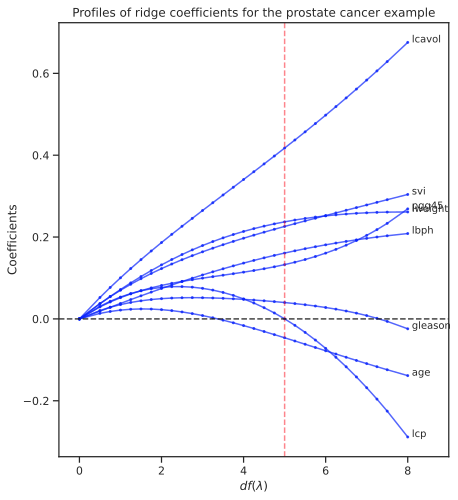

In [93]:
lr.plot_figure_3_8()

### The SVD and the principal components

The SVD of the centered matrix $\mathbf{X}$ is another way of expressing the *principal components* of the variables in $\mathbf{X}$. The sample covariance matrix is given by

\begin{equation}
\mathbf{S} = \frac{1}{N}\mathbf{X}^T\mathbf{X},
\end{equation}

and via the SVD,

\begin{equation}
\mathbf{X}^T\mathbf{X} = \mathbf{VD}^2\mathbf{V}^T,
\end{equation}

which is the *eigen decomposition* of $\mathbf{X}^T\mathbf{X}$ (and of $\mathbf{S}$, up to a factor $N$). The eigenvectors $v_j$ (columns of $\mathbf{V}$) are also called the *principal components* (or Karhunen-Loeve) directions of $\mathbf{X}$. The first principal component direction $v_1$ has the property that $\mathbf{z}_1 = \mathbf{X}v_1$ has the larger sample projected variance than any other direction. This sample variance is easily seen to be

\begin{equation}
\text{Var}(\mathbf{z}_1) = \text{Var}(\mathbf{X}v_1) = \frac{d_1^2}{N},
\end{equation}

and in fact $\mathbf{z}_1 = \mathbf{X}v_1 = \mathbf{u}_1 d_1$. The derived variable $z_1$ is called the first principal component of $\mathbf{X}$, and hence $\mathbf{u}_1$ is the normalized first principal component. And subsequent principal components $z_j$ have maximum variance $d_j^2/N$, subject to being orthogonal to the earlier ones. Conversely the last principal component has minimum variance. __Hence the small singular values $d_j$ correspond to directions in the $\text{col}(\mathbf{X})$ having small variance, and ridge regression shrinks these directions the most__. In simple words, it does not care what seems not worth. 

In [79]:
# let's find X's pca and variance ratio
x_cov_mat = np.cov(lr.x_train, rowvar=False)
x_eigenvalue, x_eigenvector = np.linalg.eig(x_cov_mat)
eigen_sum = np.sum(x_eigenvalue)
# variance explained
var_ratio = [e/eigen_sum for e in x_eigenvalue]
x_pca = pd.DataFrame({
    'var_ratio':var_ratio,
    'variable': lr.x_train.columns
})
x_pca = x_pca.sort_values(by=['var_ratio'], ascending=False)
x_pca

,var_ratio,variable
0,0.423415,lcavol
1,0.211175,lweight
2,0.128048,age
7,0.074526,pgg45
6,0.060759,gleason
5,0.047337,lcp
4,0.033439,svi
3,0.021301,lbph


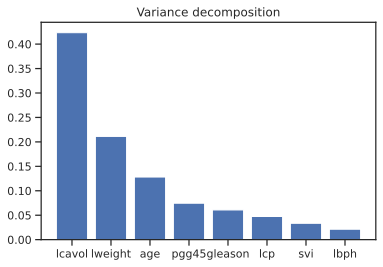

In [82]:
plt.bar(x_pca['variable'], x_pca['var_ratio'])
plt.title("Variance decomposition")
plt.show()

,variable,Value
0,Intercept,2.452
1,lcavol,0.377
2,lweight,0.222
3,age,-0.025
4,lbph,0.145
5,svi,0.214
6,lcp,-0.005
7,gleason,0.032
8,pgg45,0.139
9,Test Error,0.511


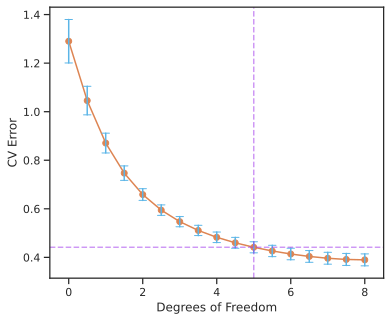

In [147]:
lr.cross_validation_ridge()

## 3.4.2. The Lasso

The lasso estimate is defined by

\begin{equation}
\hat\beta^{\text{lasso}} = \arg\min_\beta \sum_{i=1}^N \left( y_i-\beta_0-\sum_{j=1}^p x_{ij}\beta_j \right)^2 \text{ subject to } \sum_{j=1}^p |\beta_j| \le t,
\end{equation}

Just as in ridge regression, we can re-parametrize the constant $\beta_0$ by standardizing the predictors; $\hat\beta_0 = \bar{y}$, and thereafter we fit a model without an intercept.

In the signal processing literature, the lasso is a.k.a. *basis pursuit* (Chen et al., 1998).

Also the lasso problem has the equivalent *Lagrangian form*

\begin{equation}
\hat\beta^{\text{lasso}} = \arg\min_\beta \left\lbrace \frac{1}{2}\sum_{i=1}^N \left( y_i-\beta_0-\sum_{j=1}^p x_{ij}\beta_j \right)^2 + \lambda\sum_{j=1}^p |\beta_j| \right\rbrace,
\end{equation}

which is similar to the ridge problem as the $L_2$ ridge penalty is replaced by the $L_1$ lasso penalty. This lasso constraint makes the solutions nonlinear in the $y_i$, and there is no closed form expresssion as in ridge regression. And computing the above lasso solution is a quadratic programming problem, although efficient algorithms, introduced in $\S$ 3.4.4, are available for computing the entire path of solution as $\lambda$ varies, with the same computational cost as for ridge regression.

Note that

* If $t \gt t_0 = \sum_1^p \lvert\hat\beta_j^{\text{ls}}\rvert$, then $\hat\beta^{\text{lasso}} = \hat\beta^{\text{ls}}$.
* Say, for $t = t_0/2$, then the least squares coefficients are shrunk by about $50\%$ on average.  
However, the nature of the shrinkage is not obvious, and we investigate it further later.

## 3.4.3 Discussion: Subset Selection, Ridge Regression and the Lasso

In this section we discuss and compare the three approaches discussed so far for restricting the linear regression model: subset selection, ridge regression and the lasso.

Ridge regression does a _proportional shrinkage_. Lasso _translates each coefficient by a constant factor $\lambda$_, truncating at zero. This is called “soft thresholding,” and is used in the context of wavelet-based smoothing in Section 5.9. Best-subset selection _drops all variables with coefficients smaller than the Mth largest_; this is a form of “hard-thresholding.”

Back to the nonorthogonal case; some pictures help understand their relationship. The following figure depicts the lasso (left) and ridge regression (right) when there are only two parameters. The residual sum of squares has elliptical contours, centered at the full least squares estimate. The constraint region for ridge regression is the disk $\beta_1 + \beta_2 \leq t$, while that for lasso is the diamond $|\beta_1| + |\beta_2| \leq t$. Both methods find the first point where the elliptical contours hit the constraint region. Unlike the disk, the diamond has corners; if the solution occurs at a corner, then it has one parameter $\beta_j$ equal to zero. When $p > 2$, the diamond becomes a rhomboid, and has many corners, flat edges and faces; __there are many more opportunities for the estimated parameters to be zero__. Therefore, we said that Lasso was a method of _“soft thresholding,”_ rather than a method of _proportional shrinkage_. 

![penalty-vis](https://miro.medium.com/max/761/1*nrWncnoJ4V_BkzEf1pd4MA.png)

We can generalize ridge regression and the lasso, and view them as Bayes estimates. Consider the criterion for $q \ge 0$,

\begin{equation}
\tilde\beta = \arg\min_\beta \left\lbrace \sum_{i=1}^N \left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 + \lambda\sum_{j=1}^p\lvert\beta_j\rvert^q\right\rbrace
\end{equation}

See FIGURE 3.12 in the textbook for the contours of $\sum_j\lvert\beta_j\rvert^q$.

Thinking of $\lvert\beta_j\rvert^q$ as the log-prior density for $\beta_j$, these are also the equicontours of the prior distribution of the parameters.
* $q=0$ $\Rightarrow$ variable subset selection, as the penalty simply counts the number of nonzero parameters,
* $q=1$ $\Rightarrow$ Laplace distribution with density  

\begin{equation}
\frac{1}{2\tau}\exp\left(-\lvert\beta\rvert/\tau\right),
\end{equation}

where $\tau = 1/\lambda$. In this view, the lasso, ridge, and best subset selection are Bayes estimates with different priors. Note, however, that they are derived as posterior modes, that is, maximizers of the posterior. It is more common to use the mean of the posterior as the Bayes estimate. Ridge solution is also the posterior mean, but the lasso and best subset selection are not.

Note that the lasso case is the smallest $q$ such that the constraint region is convex; non-convex constraint regions make the optimization problem more difficult.

We might try using other values of $q$ besides $0$, $1$, or $2$. Although one might consider estimating $q$ from data, our experience is that it is not worth the effort for the extra variance incurred.

Although this is the case, with $q \gt 1$, $\lvert\beta_j\rvert^q$ is differentiable at $0$, and so does not share the ability of lasso ($q=1$) for setting coefficients exactly to zero. Partly for this reason as well as for computational tractability, Zou and Hastie (2005) introduced the *elastic-net* penalty, introduced.

## 3.4.4 Least Angle Regression

## 3.5 Methods Using Derived Input Directions

In many situations we have a large number of inputs, often very correlated. The methods in this section produce a small number of linear combinations $Z_m$, $m=1,\cdots,M$ of the original inputs $X_j$, and the $Z_m$ are then used in place of the $X_j$ as inputs in regression. The methods differ in how the linear combinations are constructed.

### 3.5.1 Principal Components Regression

PCR forms the derived input columns

\begin{equation}
\mathbf{z}_m = \mathbf{X} v_m,
\end{equation}

and then regress $\mathbf{y}$ on $\mathbf{z}_1,\mathbf{z}_2,\cdots,\mathbf{z}_M$ for some $M\le p$. Since the $\mathbf{z}_m$ are orthogonal, this regression is just a sum of univariate regressions:

\begin{equation}
\hat{\mathbf{y}}_{(M)}^{\text{pcr}} = \bar{y}\mathbf{1} + \sum_{m=1}^M \hat\theta_m \mathbf{z}_m = \bar{y}\mathbf{1} + \mathbf{X}\mathbf{V}_M\hat{\mathbf{\theta}},
\end{equation}

where $\hat\theta_m = \langle\mathbf{z}_m,\mathbf{y}\rangle \big/ \langle\mathbf{z}_m,\mathbf{z}_m\rangle$. We can see from the last equality that, since the $\mathbf{z}_m$ are each linear combinations of the original $\mathbf{x}_j$, we can express the solution in terms of coefficients of the $\mathbf{x}_j$.

\begin{equation}
\hat\beta^{\text{pcr}}(M) = \sum_{m=1}^M \hat\theta_m v_m.
\end{equation}

As with ridge regression, PCR depends on the scaling of the inputs, so typically we first standardized them.

### Comparison with ridge regression

If $M=p$, since the columns of $\mathbf{Z} = \mathbf{UD}$ span the $\text{col}(\mathbf{X})$,

\begin{equation}
\hat\beta^{\text{pcr}}(p) = \hat\beta^{\text{ls}}.
\end{equation}

For $M<p$ we get a reduced regression and we see that PCR is very similar to ridge regression: both operate via the principal components of the input matrix.
* Ridge regression shrinks the coefficients of the principal components (FIGURE 3.17), shrinking more depending on the size of the corresponding eigenvalue;
* PCR discards the $p-M$ smallest eigenvalue components. 

## Discussion: A Comparison of the Selection and Shrinkage Methods

> PLS, PCR and ridge regression tend to behave similarly. Ridge regression may be preferred because it shrinks smoothly, rather than in discrete steps. Lasso falls somewhere between ridge regression and best subset regression, and enjoys some of the properties of each.